In [13]:
import sys
sys.path.append("../src")
import preprocessing
import cconfig
import clustering

# Plotting defaults
%matplotlib inline
import matplotlib.pyplot as plt

# Load data and preprocess

In [14]:
# select type of features and default values
selected_features=cconfig.SELECTED_FEATURES_PACKET
dataset_type=cconfig.DATASET_TYPE_PACKET
max_num_clusters=cconfig.DEFAULT_NUM_CLUSTERS

# Unidirectional flow

In [ ]:
# load original data in dataframes, sample, select some features and scale
df,df_Normal,df_Attack=preprocessing.data_load(0.01,None,False,dataset_type)
print(df.columns)
X=preprocessing.data_scale(df[selected_features])
X_Normal=preprocessing.data_scale(df_Normal[selected_features])
X_Attack=preprocessing.data_scale(df_Attack[selected_features])

# Bidirectional flow

In [15]:
import pickle
import pandas as pd

df_Normal=pickle.load( open( "../src/flows_normal.pickle", "rb" ) ) 
df_Attack=pickle.load( open( "../src/flows_attack.pickle", "rb" ) ) 
df=pd.concat([df_Normal,df_Attack])

In [16]:
selected_features=['fwd_packets',
       'bwd_packets', 'fwd_bytes', 'bwd_bytes']

In [17]:
X=preprocessing.data_scale(df[selected_features])
X_Normal=preprocessing.data_scale(df_Normal[selected_features])
X_Attack=preprocessing.data_scale(df_Attack[selected_features])

# KMEANS

In [ ]:
# find the best number of clusters
df_silhouette = clustering.kmeans_get_number_clusters(X_Normal)

# select best number of clusters for kmeans
max_num_clusters=df_silhouette.iloc[df_silhouette.score.idxmax() ]['Num Clusters']

# plot the result for reference
df_silhouette.plot(x='Num Clusters', y='score')

In [ ]:
# fit kmeans model with normal day data
kmeans=clustering.kmeans_train(X_Normal,int(max_num_clusters))

# predictions with attack dataset
labels=clustering.kmeans_predict(X_Attack,kmeans)

# dimensionality reduction
XR=preprocessing.get_pc(X_Attack,2)

# print results
clustering.clustering_print_results(df_Attack,labels,selected_features,XR,True,True,dataset_type+'_kmeans')

In [ ]:
# print anomalies
index_anomalies=clustering.kmeans_anomalies(X_Attack,kmeans)
df_anomalies=df_Attack.iloc[index_anomalies,:]
df_anomalies

# DBSCAN

In [ ]:
# define hyper parameters for dbscan
eps=0.5
min_samples=26

# fit and predict
dblabels=clustering.dbscan_fit_predict(eps,min_samples,X)

# do dimensionality reduction to plot
XR=preprocessing.get_pc(X,2)

# print and plot
clustering.clustering_print_results(df,dblabels,selected_features,XR,True,True,dataset_type+'_dbscan')

# OPTIC

In [ ]:
# define hyper params for optics
eps=1.5
min_samples=20

# predict using optics
labels=clustering.optics_fit_predict(X,min_samples,'dbscan', eps)

# do dimensionality reduction to plot
XR=preprocessing.get_pc(X,2)

# print and plot
clustering.clustering_print_results(df,labels,selected_features,XR,True,True,dataset_type+'_optic')

In [ ]:
df_anomalies=clustering.optics_anomalies(df,labels)
df_anomalies.sort_values(by=['total_bytes','total_packets','total_duration'],ascending=False)

# IFOREST

Variability explained by the PC: 0.9664872738200176

Exporting PACKET_IFOREST...
Number of clusters: 2

Cluster -1: 205048 data points

Cluster 1: 235075 data points

DONE.
-------------------------------------------------------


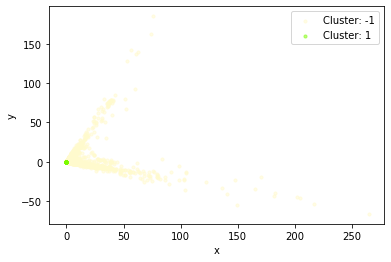

In [18]:
# model iforest
iforest=clustering.iforest_train(X_Normal)
labels=clustering.iforest_predict(X_Attack,iforest)

# dimensionality reduction
XR=preprocessing.get_pc(X_Attack,2)

# print results
clustering.clustering_print_results(df_Attack,labels,selected_features,XR,True,True,dataset_type+'_iforest')

In [ ]:
# get anomalies
df_anomalies=clustering.iforest_anomalies(df_Attack,labels)
df_anomalies.sort_values(by=['total_bytes','total_packets','total_duration'],ascending=False)

# LOF

In [ ]:
outliers_fraction=0.05
n_neighbors=30
labels=clustering.lof_fit_predict(X,outliers_fraction,n_neighbors)

# dimensionality reduction
XR=preprocessing.get_pc(X,2)

# print results
clustering.clustering_print_results(df,labels,cconfig.SELECTED_FEATURES_FLOW,XR,True,True,dataset_type+'_lof')

In [ ]:
# get anomalies
df_anomalies=clustering.lof_anomalies(df,labels)
df_anomalies.sort_values(by=['total_bytes','total_packets','total_duration'],ascending=False)

# OCSVM

In [ ]:
# train and test the model
outliers_fraction=0.05
labels=clustering.ocsvm_fit_predict(X_Normal,X_Attack,outliers_fraction)

# dimensionality reduction
XR=preprocessing.get_pc(X_Attack,3)

# print results
clustering.clustering_print_results(df_Attack,labels,cconfig.SELECTED_FEATURES_FLOW,XR,True,True,dataset_type+'_ocsvm')

In [ ]:
# get anomalies
df_anomalies=clustering.ocsvm_anomalies(df_Attack,labels)
df_anomalies.sort_values(by=['total_bytes','total_packets','total_duration'],ascending=False)